In [37]:
import pandas as pd
import geopandas as gpd
from ipyleaflet import Map, Choropleth, GeoData, LayersControl
import json
import branca.colormap
from ipywidgets import widgets
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import ticker

In [38]:
def load_data(file_path):
    data = pd.read_csv(file_path)
    return data

def check_same_entries_in_Indicator(data):
    return data['Indicator'].nunique() == 1

def plot_first_tooltip_by_location(data, period, column_name = None):
    """
    Plot the value of "First Tooltip" for Dim1 = 'Total' at a designated period for different locations.

    """
    if column_name is None and check_same_entries_in_Indicator(data):
        column_name = data['Indicator'].iloc[0]
        
    # Filter data for the specified period and Dim1 = 'Total'
    filtered_data = data[(data['Period'] == period) & (data['Dim1'] == 'Total')]


    if 'Dim1' in data.columns and set(data['Dim1'].unique()) == {'Urban', 'Total', 'Rural'}:
        # Plotting
        plt.figure(figsize=(12, 8))
        sns.barplot(x='Location', y='First Tooltip', data=filtered_data)
        plt.title(f'{column_name}for Dim1 = Total at Period {period}')
        plt.xlabel('Location')
        plt.ylabel(f'{column_name}')
        plt.legend(title='Indicator', bbox_to_anchor=(1, 1))
        plt.show()
    else:
        print("Dim1 column does not meet the specified criteria.")
        
# lineplot
def lineplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    sns.lineplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time")
    plt.ylabel(f"{df.Indicator[0]}")
    plt.legend(loc = "lower right")
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()
    
# scatterplot
def scatterplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    sns.scatterplot(data=df_location, x='Period', y='First Tooltip', hue = "Dim1")
    plt.gca().xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.0f}"))
    plt.gca().yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:.2f}"))
    plt.xlabel("Time")
    plt.ylabel(f"{df.Indicator[0]}")
    plt.legend(loc = "lower right")
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()

# barplot
def barplot(df, location):
    mask = df["Location"] == location
    df_location = df[mask]
    sns.barplot(data=df_location, x='Dim1', y = "First Tooltip", hue = "Period")
    plt.xlabel("Time")
    plt.ylabel(f"{df.Indicator[0]}")
    plt.legend(loc = "lower right")
    plt.title(f"{df.Indicator[0]} in {location} over Time")
    plt.style.use('fivethirtyeight')
    plt.show()


In [39]:
file_path = "safelySanitization.csv"
health_data = load_data(file_path)
health_data.head()

,Location,Indicator,Period,Dim1,First Tooltip
0,Albania,Population using safely managed sanitation ser...,2017,Total,39.86
1,Albania,Population using safely managed sanitation ser...,2017,Urban,40.17
2,Albania,Population using safely managed sanitation ser...,2017,Rural,39.39
3,Albania,Population using safely managed sanitation ser...,2016,Total,39.85
4,Albania,Population using safely managed sanitation ser...,2016,Urban,40.17


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


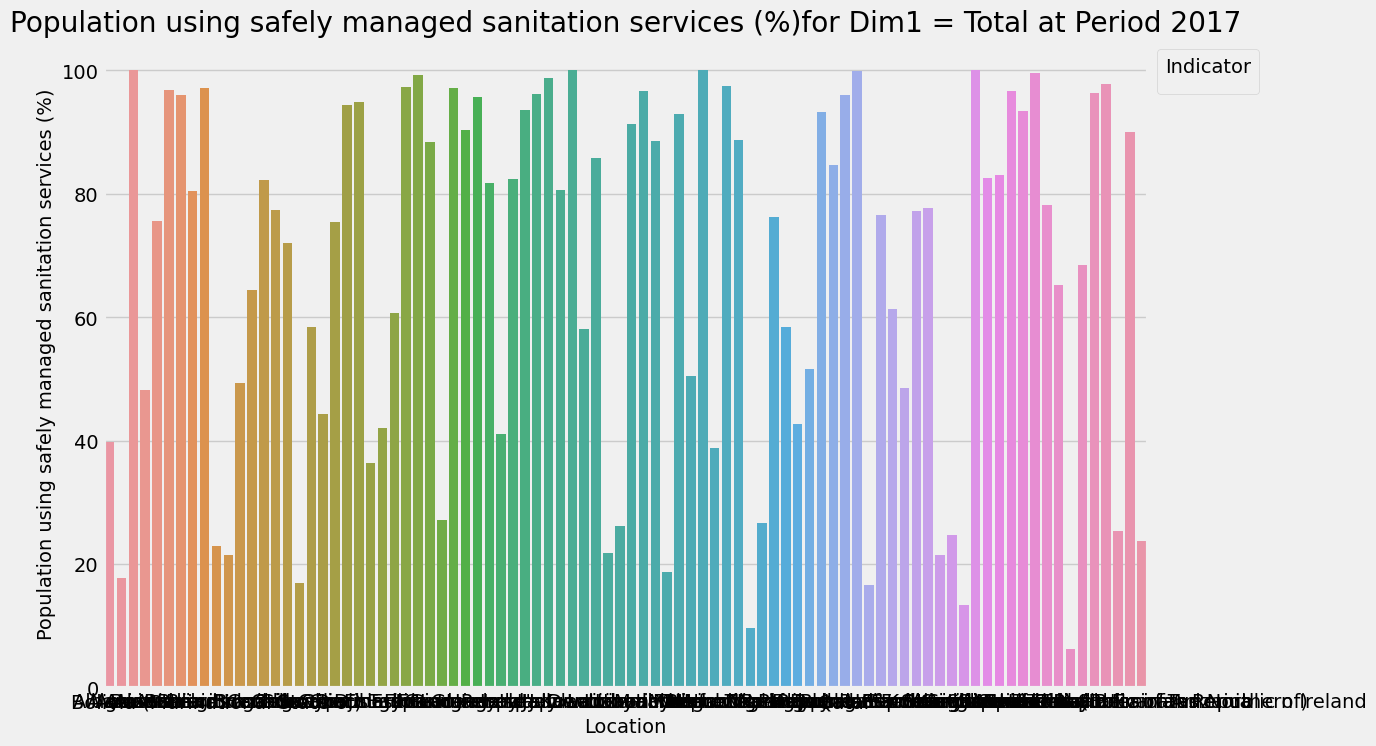

In [40]:
plot_first_tooltip_by_location(health_data, 2017)

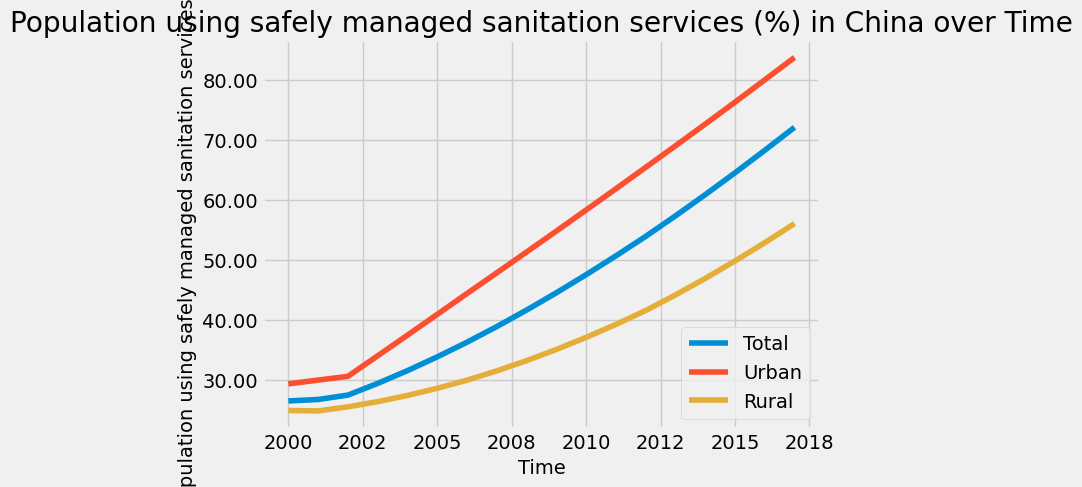

In [41]:
lineplot(health_data, "China")

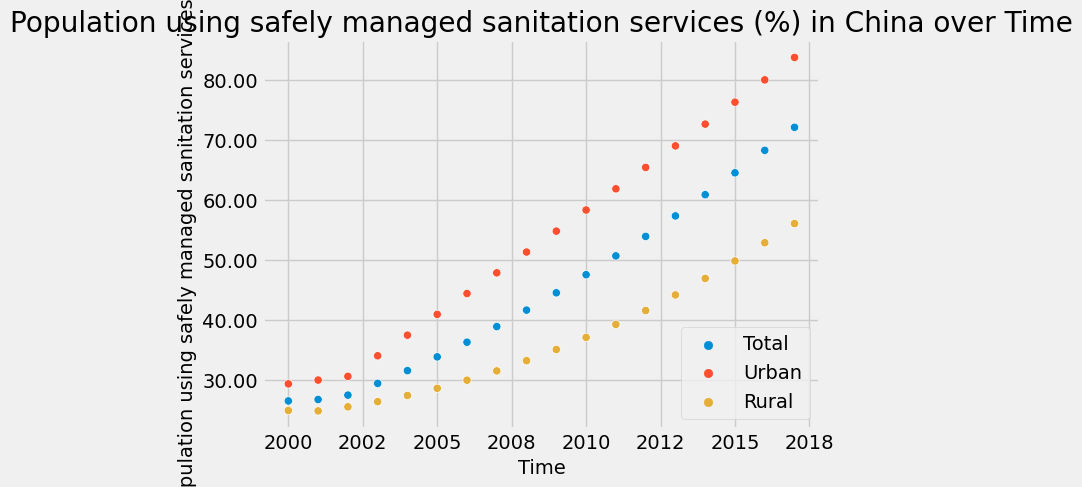

In [42]:
scatterplot(health_data, "China")

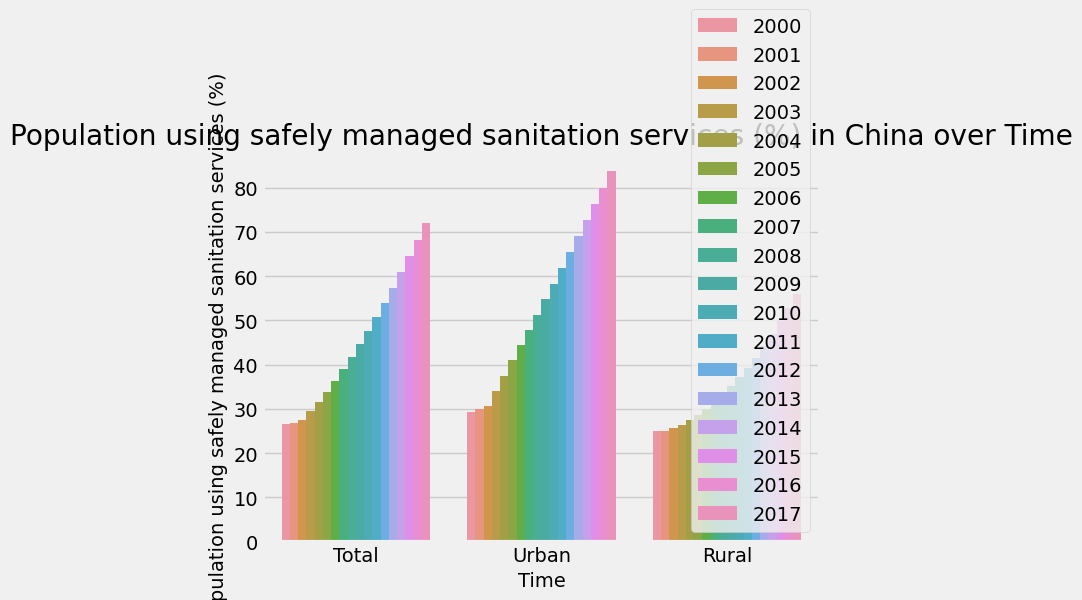

In [43]:
barplot(health_data, "China")